In [7]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# basic algebra and system libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as path
import pandas as pd
import gc
from tqdm import tqdm
import datetime
import seaborn as sns

# signal discrete fourier transform and loading
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import scipy.fft as fft

# audio preprocessing, cross-validation, and others
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight

# construction of convolutional neural network
import keras
import keras.optimizers as optimizers
import keras.layers as layers
import keras.losses as losses
import keras.metrics as metrics
import keras.regularizers as regularizers
from tensorflow.keras import Input
from tensorflow.keras.callbacks import TensorBoard

# audio analysis
import librosa
import librosa.display

# processing speedup using GPU
import tensorflow as tf

# allow GPU computation to exceed system memory for a certain amount
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Load audio data paths and metadata
metadata = []
data_dir = os.path.join("..", "data", "raw")
class_1_speakers = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            speaker_id = file.split('_')[0]
            label = 1 if speaker_id in class_1_speakers else 0
            metadata.append({
                'path': os.path.join(root, file),
                'label': label
            })

metadata_df = pd.DataFrame(metadata)
metadata_df.head()
len(metadata)

101

In [4]:
def load_and_split_audio(file_path, target_sr=16000, segment_length=1):
    # Load audio
    audio, sr = librosa.load(file_path, sr=target_sr)
    total_length = len(audio) / sr
    segments = []
    
    # Split audio into segments of length 'segment_length'
    for start in np.arange(0, total_length, segment_length):
        end = start + segment_length
        segment = audio[int(start*sr):int(end*sr)]
        # Pad if the segment is shorter
        if len(segment) < segment_length * sr:
            segment = np.pad(segment, (0, int(segment_length * sr) - len(segment)), mode='constant')
        segments.append(segment)
    return segments

def generate_spectrograms(segments, sr=16000):
    spectrograms = []
    for segment in segments:
        # Generate Mel Spectrogram
        S = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        spectrograms.append(S_DB)
    return spectrograms

# Apply load and split
metadata_df['segments'] = [load_and_split_audio(x) for x in tqdm(metadata_df['path'], desc="Loading and Splitting Audio Files")]
metadata_df = metadata_df.explode('segments')

# Generate spectrograms
metadata_df['spectrograms'] = [generate_spectrograms([x])[0] for x in tqdm(metadata_df['segments'], desc="Generating Spectrograms")]

print(f"Total number of spectrograms generated: {len(metadata_df)}")
metadata_df.head()

Generating Spectrograms: 100%|█████████████████| 16320/16320 [03:11<00:00, 85.22it/s]


Total number of spectrograms generated: 16320


,path,label,segments,spectrograms
0,../data/raw/m9_script2_clean.wav,0,"[0.0021410338, 0.0040319115, 0.0035175383, 0.0...","[[-5.645678, -4.1331897, -4.765756, -3.778256,..."
0,../data/raw/m9_script2_clean.wav,0,"[0.0060567423, 0.0060815765, 0.0061656404, 0.0...","[[-4.120476, -2.788724, -4.6016483, -3.2616549..."
0,../data/raw/m9_script2_clean.wav,0,"[0.00046622416, 0.00042011004, 0.0004739756, 0...","[[-15.1823845, -9.561183, -4.2944355, -1.41947..."
0,../data/raw/m9_script2_clean.wav,0,"[0.001471748, 0.0015036843, 0.0014837051, 0.00...","[[-7.374747, -1.1565208, -1.0960851, -1.654888..."
0,../data/raw/m9_script2_clean.wav,0,"[0.0045290147, 0.0045478446, 0.0046075853, 0.0...","[[-5.911895, -4.391842, -3.7729778, -4.379524,..."


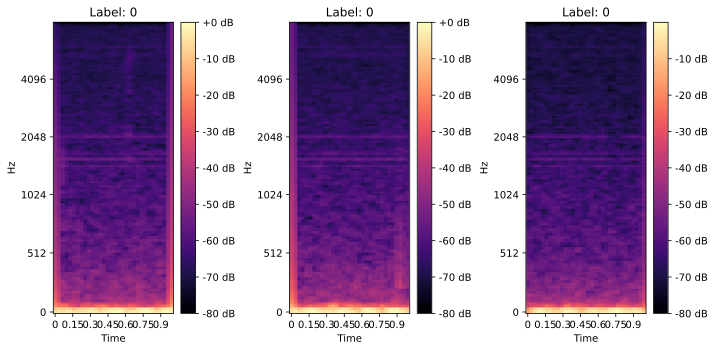

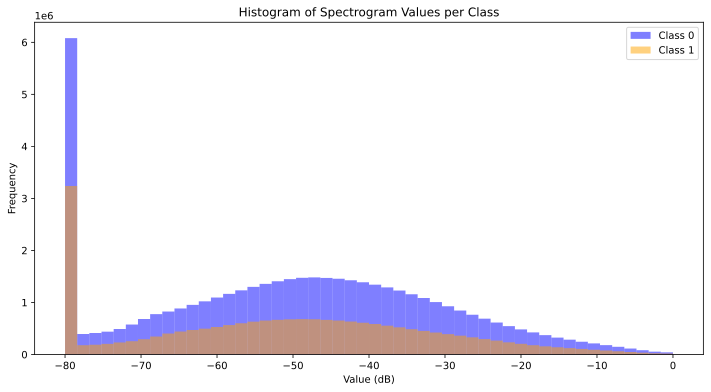

In [5]:
# Plot some example spectrograms
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    librosa.display.specshow(metadata_df.iloc[i]['spectrograms'], sr=16000, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f"Label: {metadata_df.iloc[i]['label']}")
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Histogram of spectrogram values per class
class_0_spectrograms = metadata_df[metadata_df['label'] == 0]['spectrograms'].values
class_1_spectrograms = metadata_df[metadata_df['label'] == 1]['spectrograms'].values

# Flatten spectrogram values
class_0_values = np.concatenate([s.ravel() for s in class_0_spectrograms])
class_1_values = np.concatenate([s.ravel() for s in class_1_spectrograms])

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(class_0_values, bins=50, alpha=0.5, label='Class 0', color='blue')
plt.hist(class_1_values, bins=50, alpha=0.5, label='Class 1', color='orange')
plt.title("Histogram of Spectrogram Values per Class")
plt.xlabel("Value (dB)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [12]:
X = np.stack(metadata_df['spectrograms'].values)
X = X[..., np.newaxis]  # Add channel dimension for CNN
Y = metadata_df['label'].values

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create basic CNN model
def create_cnn():
    inputs = Input(shape=(128, 32, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn()

# Set up TensorBoard callback
log_dir = os.path.join("logs", "fit") + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model
history = model.fit(
    X_train, Y_train, 
    epochs=5, 
    batch_size=32,
    validation_data=(X_test, Y_test), 
    callbacks=[tensorboard_callback],
    class_weight=dict(enumerate(compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)))
)

Epoch 1/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - accuracy: 0.5866 - loss: 0.8407 - val_accuracy: 0.6719 - val_loss: 0.5809
Epoch 2/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.7500 - loss: 0.4753 - val_accuracy: 0.8551 - val_loss: 0.3332
Epoch 3/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 43s 105ms/step - accuracy: 0.8510 - loss: 0.3338 - val_accuracy: 0.8857 - val_loss: 0.2782
Epoch 4/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 43s 106ms/step - accuracy: 0.9058 - loss: 0.2266 - val_accuracy: 0.9271 - val_loss: 0.1839
Epoch 5/5
408/408 ━━━━━━━━━━━━━━━━━━━━ 43s 105ms/step - accuracy: 0.9310 - loss: 0.1642 - val_accuracy: 0.9491 - val_loss: 0.1335


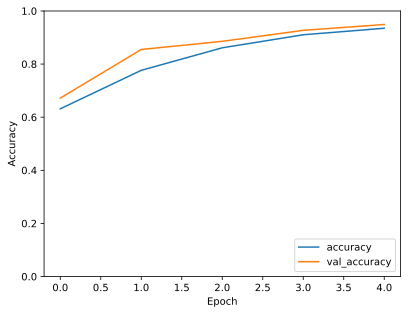

In [13]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [14]:
# Generate predictions and calculate metrics
Y_pred = (model.predict(X_test) > 0.5).astype('int32')

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)

# Compute the macro-average F1 score
macro_f1 = f1_score(Y_test, Y_pred, average='macro')

# Calculate precision and recall
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')

# Output the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Macro F1: {macro_f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Show class report
class_report = classification_report(Y_test, Y_pred)
print(class_report)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


NameError: name 'accuracy_score' is not defined

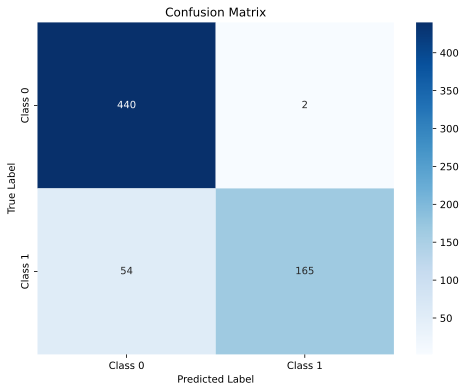

In [31]:
# Plot confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()